In [1]:
import json
import time
from collections import defaultdict

import matplotlib.pyplot as plt
import torch
import math
from typing import Optional, Any
import numpy as np
import pickle

from custom_buffer import WeightedReplayBuffer

from pearl.replay_buffers import BasicReplayBuffer
from pearl.utils.instantiations.spaces import DiscreteActionSpace
from pearl import PearlAgent
from pearl.utils.functional_utils.train_and_eval.learning_logger import LearningLogger, null_learning_logger
from pearl.utils.functional_utils.experimentation.set_seed import set_seed
from pearl.utils.functional_utils.train_and_eval.offline_learning_and_evaluation import TRAINING_TAG
from pearl.replay_buffers import TransitionBatch, ReplayBuffer
from pearl.policy_learners.sequential_decision_making.double_dqn import DoubleDQN
from pearl.neural_networks.sequential_decision_making import VanillaContinuousActorNetwork
from pearl.policy_learners.sequential_decision_making import ImplicitQLearning
from pearl.utils.functional_utils.train_and_eval.offline_learning_and_evaluation import offline_evaluation,offline_learning
from pearl.neural_networks.sequential_decision_making.q_value_networks import VanillaQValueNetwork, VanillaQValueMultiHeadNetwork
from pearl.action_representation_modules.one_hot_action_representation_module import (
    OneHotActionTensorRepresentationModule,
)
from pearl.neural_networks.sequential_decision_making.q_value_networks import MultiAgentQValueMultiHeadNetwork


set_seed(42)


In [2]:
FRONTIER_COUNT:int = 6 # the maximum number of selected frontiers
FRONTIER_FEATURES:int = 6 # the number of features measured for each frontier
OTHER_FRONTIER_INPUTS:int = 3 # other observations (current % explored area)

OBSERVATION_SPACE:int = FRONTIER_COUNT*FRONTIER_FEATURES+OTHER_FRONTIER_INPUTS
ACTION_SPACE:int = FRONTIER_COUNT

In [3]:
if torch.cuda.is_available():
    num_gpus = torch.cuda.device_count()
    print(f"Number of GPUs: {num_gpus}")
    for i in range(num_gpus):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("No GPUs available.")

No GPUs available.


In [4]:
replay_buffer_size = 1_000_000
device_id = 0
is_action_continuous = False
data_file_paths = [
    "data/rl-run-data.json", 
    "data/rl-run-dqn-1-data.json",
    "data/rl-run-dqn-7-data.json"]
# data_file_paths = ["data/rl-run-data.json"]
max_number_actions_if_discrete = ACTION_SPACE
loss_log_file = "loss.log"

In [5]:
def load_transitions(buffer, path):
    with open(path, "r") as f:
        data_transitions = json.load(f)
    
    count = 0
    for map_name in data_transitions:
        for i in range(len(data_transitions[map_name])):
            transitions = data_transitions[map_name][i]["run"]
            episode = defaultdict(list)
            for j in range(len(transitions["obs"])):
                transition = {}
                
                transition["observation"] = np.array(transitions["obs"][j], dtype=np.float32)
                transition["action"] = np.argmax(transitions["action"][j])
                transition["next_observation"] = np.array(transitions["next_obs"][j], dtype=np.float32)
                transition["reward"] = np.float32(
                    transitions["reward"][j][0] +
                    10*transitions["obs"][j][37]*transitions["obs"][j][38]
                )
                transition["curr_available_actions"] = DiscreteActionSpace(
                    actions=list(
                        torch.arange(len(transitions["action"][j])).view(-1, 1)
                    )
                )
                transition["next_available_actions"] = DiscreteActionSpace(
                    actions=list(
                        torch.arange(len(transitions["action"][j])).view(-1, 1)
                    )
                )
                transition["terminated"] = False
                transition["truncated"] = False
                
                # Ignore terminated transitions
                if transition["reward"] > 0.995:
                    continue
                    
                # Suffle frontier order
                permutation = np.random.permutation(FRONTIER_COUNT)
                
                for obs in ["observation", "next_observation"]:
                    for i in range(FRONTIER_FEATURES):               
                        transition[obs][FRONTIER_COUNT*i:FRONTIER_COUNT*(i+1)] = transition[obs][FRONTIER_COUNT*i:FRONTIER_COUNT*(i+1)][permutation]
                
                transition["action"] = permutation[transition["action"]]

                assert len(transitions["action"][j]) == ACTION_SPACE
                assert len(transition["observation"]) == OBSERVATION_SPACE
                assert len(transition["next_observation"]) == OBSERVATION_SPACE
                
                count += 1
                for key in transition:
                    episode[key].append(transition[key])
                    
            buffer.add_traj(episode, map_name)
    print(f"Loaded {count} transitions from {path}")

In [7]:
offline_data_replay_buffer = WeightedReplayBuffer(0.2)
print("Loading data in buffer...")
for data_path in data_file_paths:
    load_transitions(offline_data_replay_buffer, data_path)

print("Building buffer...")
offline_data_replay_buffer.build_memory()

Loading data in buffer...
Loaded 206585 transitions from data/rl-run-data.json
Loaded 327293 transitions from data/rl-run-dqn-1-data.json
Loaded 571913 transitions from data/rl-run-dqn-7-data.json
Building buffer...


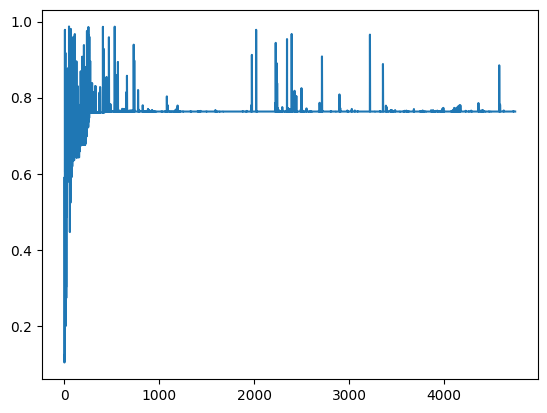

In [17]:
indices = np.where(offline_data_replay_buffer._weights == np.max(offline_data_replay_buffer._weights))[0]
rewards = []
for idx in indices:
    rewards.append(offline_data_replay_buffer._memory[idx].reward[0])
    
plt.plot(rewards)
plt.show()

In [18]:
offline_data_replay_buffer._memory[indices[-1]]

Transition(state=tensor([[0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 7.2606e-02, 0.0000e+00,
         0.0000e+00, 6.1047e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 9.4904e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 5.2174e-01, 0.0000e+00,
         7.3021e-01, 4.2876e-05, 0.0000e+00]]), action=tensor([2], dtype=torch.int32), reward=tensor([0.7636]), terminated=tensor([False]), truncated=tensor([False]), next_state=tensor([[0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 7.2223e-02, 0.0000e+00,
         0.0000e+00, 6.3857e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e

In [7]:
def loss_learning_logger(
    results: dict[str, Any],
    step: int,
    batch: Optional[TransitionBatch] = None,
    prefix: str = "",
) -> None:
    """
    A learning logger that does nothing.
    """
    if "loss" in results:
        with open(loss_log_file, "a") as f:
            f.write(results["loss"] + "\n")

In [8]:

Q_value_network = MultiAgentQValueMultiHeadNetwork(
    state_dim=OBSERVATION_SPACE,  # dimension of the state representation
    action_dim=ACTION_SPACE,                    # dimension of the action representation
    hidden_dims=[256,256],                   # dimensions of the intermediate layers
    output_dim=ACTION_SPACE,
    global_features=3,
    local_features=6,
)    

action_space = DiscreteActionSpace(
    actions=list(torch.arange(ACTION_SPACE).view(-1, 1))
)

agent = PearlAgent(
    policy_learner=DoubleDQN(
        state_dim=OBSERVATION_SPACE,
        action_space=action_space,
        batch_size=512,
        training_rounds=10,
        soft_update_tau=0.75,
        network_instance=Q_value_network, # pass an instance of Q value network to the policy learner.
        action_representation_module=OneHotActionTensorRepresentationModule(
            max_number_actions=ACTION_SPACE
        ),
        is_conservative=True
    ),
    # device_id=device_id,
)


In [10]:
# Number of training epochs
training_epochs = 100
experiment_seed = 100

with open(loss_log_file,"w") as f:
    pass

offline_learning(
    offline_agent=agent,
    data_buffer=offline_data_replay_buffer, # replay buffer created using the offline data
    training_epochs=training_epochs,
    seed=experiment_seed,
)

KeyboardInterrupt: 

In [10]:
with open("agent.pkl", "wb") as f:
    pickle.dump(agent, f)
    

torch.save(agent.policy_learner._Q._model, "Q_function.pth")

In [11]:
trans = offline_data_replay_buffer.sample(1)
agent.reset(trans.state[0],action_space)
agent.act(exploit=True)

ValueError: Can't get a batch of size 1 from a replay buffer with only 0 elements

In [27]:
agent.policy_learner._Q._model

KeyboardInterrupt: 